In [64]:
# Generic imports:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import math, random, re
import time
import pickle
from Bio import SeqIO

In [65]:
# Machine learning/Stats imports:
from scipy.stats import norm
from scipy.stats import spearmanr,pearsonr
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Bidirectional, RepeatVector, Reshape, LSTM
from keras.models import Model
from keras import regularizers
from keras import optimizers
from keras.layers import Input, Dense, Lambda, Dropout,Activation, TimeDistributed
from keras import backend as K
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import regularizers

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

In [66]:
# Amino acid alphabet:
AA_ORDER = 'ACDEFGHIKLMNPQRSTVWY-'
AA_LIST = list(AA_ORDER)
AA_DICT = {c:i for i, c in enumerate(AA_LIST)}
AA_DICT_REV = {i:c for i, c in enumerate(AA_LIST)}
AA_SET = set(AA_LIST)

In [67]:
def filter_seq(seq):
    '''Filter away ambiguous character containing sequences.'''
    if set(list(seq)) <= AA_SET:
        return(seq)
    else:
        return(None)

In [68]:
def seq2onehot(seq_list):
    '''
    Translate a list of amino acid sequences into a 3D tensor with onehot encodings.
    NB. all sequences must be of equal length.
    '''
    seqlen = len(seq_list[0])
    assert(not [True for s in seq_list if len(s) != seqlen])
    onehot_tensor = np.zeros((len(seq_list), seqlen, len(AA_SET)))
    for i, seq in enumerate(seq_list):
        for j, a in enumerate(seq):
            onehot_tensor[i][j][AA_DICT[a]] = 1
    return(onehot_tensor)

In [69]:
def onehot2seq(onehot_tensor):
    '''
    Translate a 3D tensor with onehot encodings to a list of amino acid sequences.
    '''
    seq_list = list()
    for i in range(onehot_tensor.shape[0]):
        seq = list()
        for j in range(onehot_tensor.shape[1]):
            seq.append(AA_DICT_REV[onehot_tensor[i][j].argmax()])
        seq_list.append(''.join(seq))
    return(seq_list)

In [70]:
# Read in some sequences:
MAX_SEQS = 10000000
MAX_LEN = 149
fnam = '../spurf_heavy_chain_AHo.fasta'
#fnam = '../spurf_heavy_chain.fasta'
seq_list = list()
for i, record in enumerate(SeqIO.parse(fnam, 'fasta')):
    if i >= MAX_SEQS:
        break
    seq = str(record.seq)
    if len(seq) > MAX_LEN:
        continue
    else:
        seq += '-' * (MAX_LEN - len(seq))
        seq_list.append(seq)
        
print('Input data has {} sequences.'.format(len(seq_list)))
print('This is how a typical sequence looks:\n{}'.format(seq_list[0]))

Input data has 1602878 sequences.
This is how a typical sequence looks:
EVQLVES-GGGLVQPGGSLRLSCAASG-FPSNS-----YWMTWVRQAPGKGLEWVANINED---GSERYYVDSVKGRFTISRDNAKNSQYLQMNSLRAEDTAVYYCTRDVWF---------------------GFFDIWGQGTTVIVSS


In [71]:
# Transform to onehot:
onehot_tensor = seq2onehot(seq_list)
print('                                      (samples, MAX_LEN, N_characters)')
print('Onehot encoded tensor has this shape: {}'.format(onehot_tensor.shape))

                                      (samples, MAX_LEN, N_characters)
Onehot encoded tensor has this shape: (1602878, 149, 21)


In [81]:
# Various network definitions:
batch_size = 100
input_shape = onehot_tensor.shape[1:]
input_total_dim = np.array(input_shape).prod()

latent_dim = 200
dense_nodes = 500

epsilon_std = 1.0
def sampling(args):
    '''This function draws a sample from the multinomial defined by the latent variables.'''
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.0, stddev=epsilon_std)
    return(z_mean + K.exp(z_log_var / 2) * epsilon)

def vae_loss(io_encoder, io_decoder):
    '''The loss function is the sum of the cross-entropy and KL divergence.'''
    # Notice that "objectives.categorical_crossentropy(io_encoder, io_decoder)"
    # is a vector so it is averaged using "K.mean":
    xent_loss = input_total_dim * K.mean(objectives.categorical_crossentropy(io_encoder, io_decoder))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return(xent_loss + kl_loss)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 149, 21)           0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 3129)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 500)               1565000   
_________________________________________________________________
dense_46 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_47 (Dense)             (None, 200)               100200    
Total params: 1,915,700
Trainable params: 1,915,700
Non-trainable params: 0
_________________________________________________________________


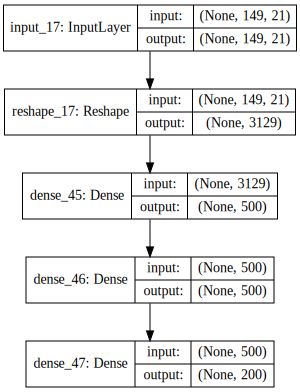

In [82]:
# Encoding layers:
io_encoder = Input(shape=input_shape)
reshape2flat = Reshape([int(input_total_dim)])(io_encoder)
dense_encoder1 = Dense(dense_nodes, activation='elu')(reshape2flat)
dense_encoder2 = Dense(dense_nodes, activation='elu')(dense_encoder1)


# Latent layers:
z_mean = Dense(latent_dim)(dense_encoder2)
z_log_var = Dense(latent_dim)(dense_encoder2)
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean, z_log_var])

encoder = Model(io_encoder, z_mean)
encoder.summary()
#plot_model(encoder, to_file='encoder.svg', show_shapes=True)
SVG(model_to_dot(encoder, show_shapes=True).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 200)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 500)               100500    
_________________________________________________________________
dense_50 (Dense)             (None, 3129)              1567629   
_________________________________________________________________
reshape_18 (Reshape)         (None, 149, 21)           0         
_________________________________________________________________
activation_4 (Activation)    (None, 149, 21)           0         
Total params: 1,668,129
Trainable params: 1,668,129
Non-trainable params: 0
_________________________________________________________________


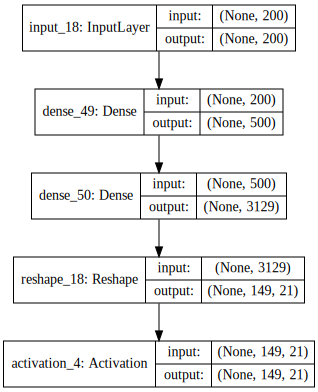

In [83]:
# Decoding layers:
dense_decoder1 = Dense(dense_nodes, activation='elu')
decoder_out = Dense(input_total_dim, activation='linear')
reshape2input = Reshape(input_shape)
# The probability of all the different characters should sum to 1 for each position:
position_wise_softmax = Activation(activation='softmax')
io_decoder = position_wise_softmax(reshape2input(decoder_out(dense_decoder1(z))))

io_z = Input(shape=(latent_dim,))
io_decoder_means = position_wise_softmax(reshape2input(decoder_out(dense_decoder1(io_z))))
decoder = Model(io_z, io_decoder_means)
decoder.summary()
#plot_model(decoder, to_file='decoder.svg', show_shapes=True)
SVG(model_to_dot(decoder, show_shapes=True).create(prog='dot', format='svg'))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 149, 21)       0                                            
____________________________________________________________________________________________________
reshape_17 (Reshape)             (None, 3129)          0           input_17[0][0]                   
____________________________________________________________________________________________________
dense_45 (Dense)                 (None, 500)           1565000     reshape_17[0][0]                 
____________________________________________________________________________________________________
dense_46 (Dense)                 (None, 500)           250500      dense_45[0][0]                   
___________________________________________________________________________________________

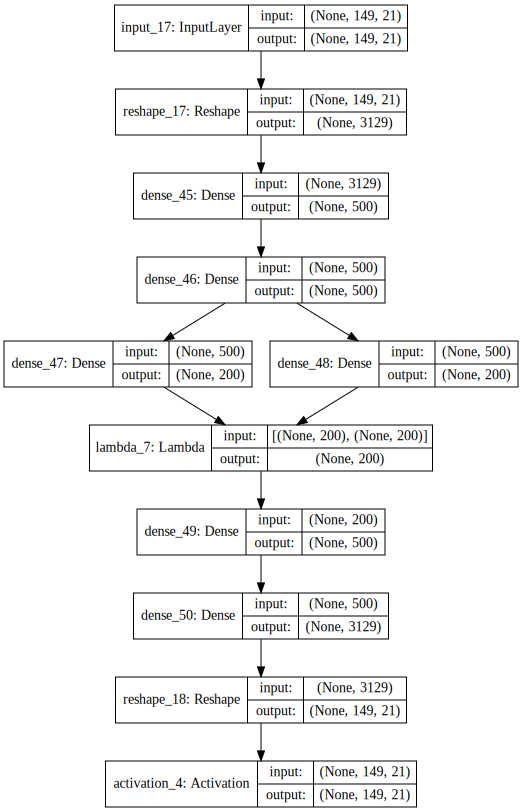

In [84]:
vae = Model(io_encoder, io_decoder)
vae.compile(optimizer="adam", loss=vae_loss)
vae.summary()
#plot_model(vae, to_file='vae.svg', show_shapes=True)
SVG(model_to_dot(vae, show_shapes=True).create(prog='dot', format='svg'))

In [76]:
# Split dataset into train/test:
x_train, x_test = train_test_split(onehot_tensor, test_size=0.1, shuffle=True)
sl = len(x_train) // (batch_size*10)
#sl = sl // 10  # downsample by 10x
x_train = x_train[:(sl*batch_size*10)]

In [85]:
nb_epoch = 2
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
vae_log = vae.fit(x_train,
                  x_train,  # VAE is unsupervised so y=X
                  shuffle=True,
                  epochs=nb_epoch,
                  batch_size=batch_size,
                  validation_split=0.1,
                  callbacks=[early_stopping])

Train on 1297800 samples, validate on 144200 samples
Epoch 1/2
1297800/1297800 [==============================] - 1007s - loss: 465.2556 - val_loss: 336.8118
Epoch 2/2
1297800/1297800 [==============================] - 1005s - loss: 316.3272 - val_loss: 309.9752


In [ ]:
# Save/load trained weights:
#vae.save('two_layer_vae.h5')
#vae.load_weights('two_layer_vae.h5')

In [86]:
# Encode a chunk of testset data into latent space:
chunk = 10000
x_test_encoded = encoder.predict(x_test[0:chunk])
print('Output shape:', x_test_encoded.shape)

Output shape: (10000, 200)


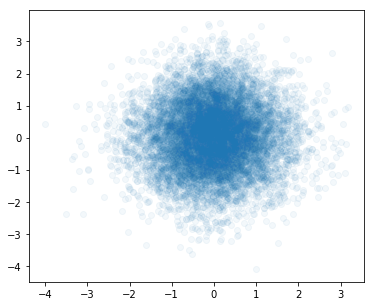

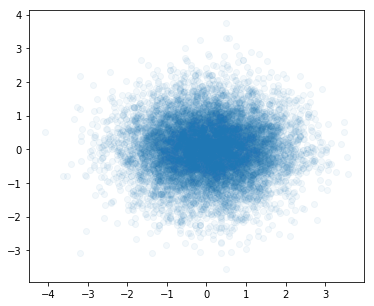

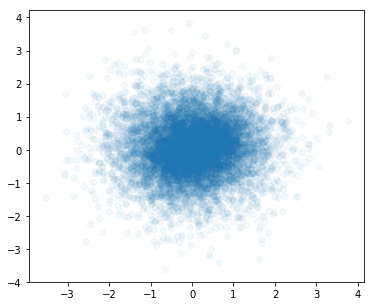

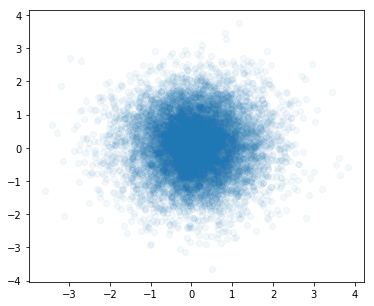

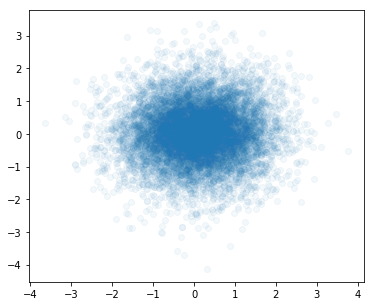

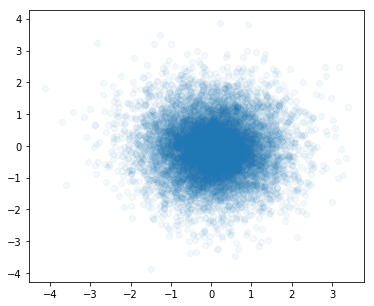

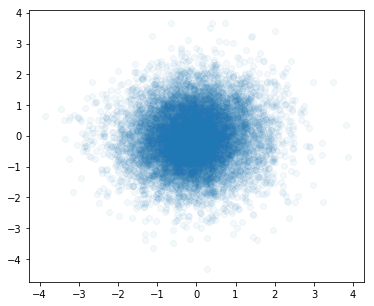

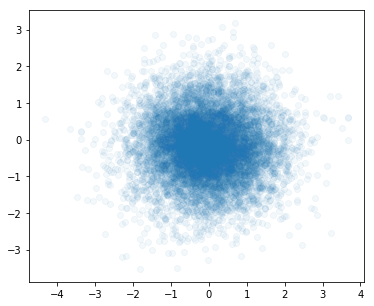

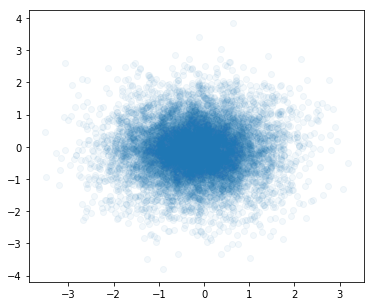

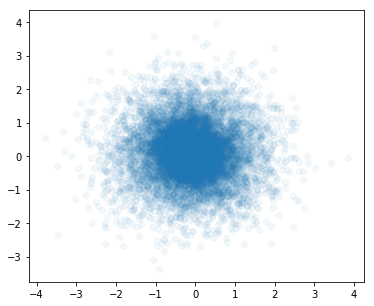

In [257]:
# Take a quick look at the latent space:
for i in range(10):
    x = list(x_test_encoded[:, i])
    y = list(x_test_encoded[:, i+1])
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, alpha=0.05);

In [88]:
# Do a PCA to see how much explained variance that can be extracted
# from any two dimensional combination of the latent space:
pca = PCA(n_components=2)
pca.fit(x_test_encoded)
print('PCA total explained variance in two dimensions is {:.3}%'.format(pca.explained_variance_ratio_.sum() * 100))

PCA total explained variance in two dimensions is 3.59%


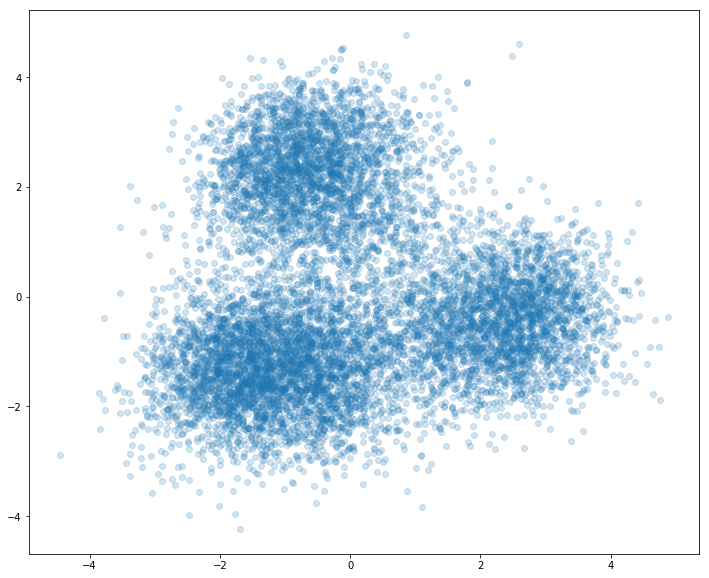

In [261]:
# Plot the PCA results:
X_r = pca.fit(x_test_encoded).transform(x_test_encoded)
plt.figure(figsize=(12, 10))
x = list(X_r[:,0])
y = list(X_r[:, 1])
plt.scatter(x, y, alpha=0.2);

In [90]:
# Decode the chunk of testdata from latent space into the original input space:
x_test_decoded = decoder.predict(x_test_encoded)
print('Output shape:', x_test_decoded.shape)

Output shape: (10000, 149, 21)


In [91]:
# If, for some reason, the output was not softmaxed we would need to normalize it
# as a post fitting step:
softmax_out = True
if softmax_out is not True:
    # Normalize decoded output:
    for i in range(len(x_test_decoded)):
        x_test_decoded[i] = normalize(x_test_decoded[i], axis=1, norm='l1')
    print('This "{}" should be close to {}.'.format(sum(sum(x_test_decoded[0])), x_test_decoded.shape[1]))

In [95]:
# The softmax activation on the last layer should bound the sum of each position to 1.
# This enable us to intepret the values as probabilities.
print('The sum of character probabilities at position one is: {}'.format(str(sum(x_test_decoded[0][0]))))
print('The sum of probabilities at all {} positions one is: {}'.format(str(x_test_decoded.shape[1]), str(sum(sum(x_test_decoded[0])))))

The sum of character probabilities at position one is: 0.999999980551
The sum of probabilities at all 149 positions one is: 148.999989986


In [96]:
# Then translate the onehot encoding to a sequence:
seqs_test = onehot2seq(x_test[0:chunk])
seqs_test_decoded = onehot2seq(x_test_decoded_onehot)

In [345]:
# Finally, compare the input sequences with those that have been a roundtrip through the VAE:
mismatches = 0
print('First line is the input sequence.\nSecond line is the VAE output.\nThird line is the amino acid identity for the input sequence in case of disagreements.\nFourth line is the amino acid identity for the VAE output in case of disagreements.\n')
for i in range(10):
    print(seqs_test[i])
    print(seqs_test_decoded[i])
    print('{}'.format(''.join([' ' if i==j else i for i,j in zip(seqs_test[i], seqs_test_decoded[i])])))
    print('{}'.format(''.join([' ' if i==j else j for i,j in zip(seqs_test[i], seqs_test_decoded[i])])))
    mismatches += sum(0 if i==j else 1 for i,j in zip(seqs_test[i], seqs_test_decoded[i]))
print('\nTotal disagreements: {}'.format(mismatches))

First line is the input sequence.
Second line is the VAE output.
Third line is the amino acid identity for the input sequence in case of disagreements.
Fourth line is the amino acid identity for the VAE output in case of disagreements.

QVQLVES-GGGLVQPGGSLRLSCAASG-FTFSS-----YAMHWVRQAPGKGLEWVAAISFD---GATKYHADSVKGRFTISRDNSKNTLFLQMNSLRGDDTAVYYCARTFDLL-------------------TCFFPDWGQGTLITVSS
QVQLVES-GGGLVQPGGSLRLSCAASG-FTFSS-----YAMHWVRQAPGKGLEWVAAISFD---GRTKYHADSVKGRFTISRDNSKNTLFLQMNSLRGDDTAVYYCARTFDLL-------------------TEFFPDWGQGTLITVSS
                                                                 A                                                                   C               
                                                                 R                                                                   E               
QVQLVES-GGGVVQPGRSLRLSCAASG-FPFNN-----YVIHWVRQAPGKGLEWVAFTSYD---GNNKYYTDSVKGRFTISRDSSKNTLYLQMNNLRPEDTAVYFCAKAGPHLPGS-------------GTYRGPFDYWGQGTLVTVSS
QVQLVES-GGGVV

In [321]:
# All of our above encoding/decoding was based on single point estimates
# i.e. taking a sequence and passing it through the encoder to generate
# the sampling parameters for the latent space and then take one sample
# from this latent space and decode it using the decoder.
# Instead of just decoding one sample from the latent space we could
# decode multiple and do averaging to get a better estimate.

# Let's investigate this by computing unnormalized sequence probabilities
# and find out how many samples are needed for convergence.

def compute_log_probability(one_hot_seq, pwm):
    prod_mat = np.matmul(one_hot_seq, pwm.T)
    log_prod_diag = np.log(prod_mat.diagonal())
    sum_diag = np.sum(log_prod_diag)
    return(sum_diag)

def mean_log_prob(logPs):
    '''
    Calculate the mean of a list of log probabilities.
    Using the "log-sum-exp trick" to avoid underflow
    when taking the mean of a list of log probabilities.
    '''
    a = min(logPs)  # Offset avoids underflow
    s = sum(np.exp(lp - a) for lp in logPs)
    return(a + np.log(s / len(logPs)))

In [323]:
# Here we perform the sampling:
Nsamples = 1000
chunk = 100  # This is slow so we decrease our chunk size
x = x_test[0:chunk]
log_p_list = np.zeros((100, Nsamples))
log_mean_p = np.zeros((100, Nsamples))  # This will be a running mean of the log probabilities
for i in range(Nsamples):
    # Instead of directly sampling the latent space passing it to the decoder
    # we are lazy and let the already defined VAE object take care of it all:
    S = vae.predict(x, batch_size=batch_size)
    for j in range(chunk):
        logp = compute_log_probability(x[j], S[j])
        log_p_list[j][i] = logp
        log_mean_p[j][i] = mean_log_prob(log_p_list[j][:(i+1)])

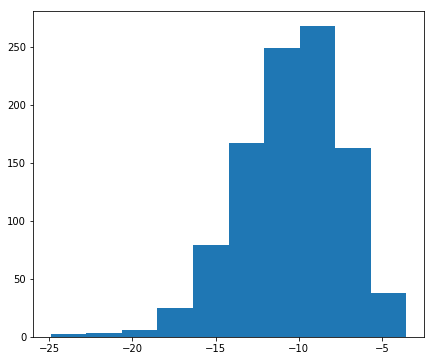

In [333]:
# Take a look at the sampling distribution of the log probabilities:
plt.figure(figsize=(7, 6))
plt.hist(log_p_list[0]);

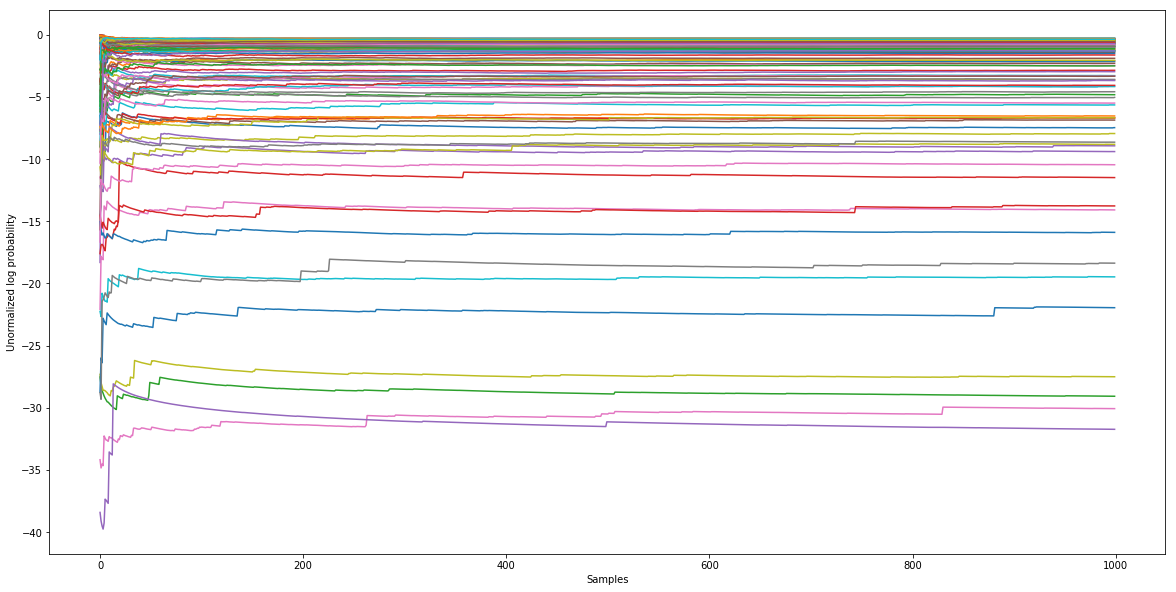

In [359]:
# It looks like we reached convergence:
plt.figure(figsize=(20, 10))
for i in range(100):
    plt.xlabel('Samples')
    plt.ylabel('Unormalized log probability')
    plt.plot(log_mean_p[i]);

In [347]:
# Having investigated this we can make our future predictions with sampling:
def vae_prediction_with_sampling(onehot, Nsamples=1000, remove_gap_predictions=True, verbose=False):
    '''
    Send a onehot on a roundtrip through the VAE.
    Many (~1000) samples will help stabilize the estimate.
    '''
    onehot_decoded = vae.predict(onehot, batch_size=batch_size)
    if verbose:
        print('Starting to sample:')
    for i in range(Nsamples-1):
        if i % 100 == 0 and verbose:
            print('Sample:', i)
        onehot_decoded += vae.predict(onehot, batch_size=batch_size)
    onehot_decoded /= Nsamples
    if verbose:
        print('Starting to normalize:')
    if remove_gap_predictions:
        # Extra gaps are not allowed, so reflect that in the normalization:
        for i in range(len(onehot_decoded)):
            if i % 100000 == 0 and verbose:
                print('At sample:', i)
            for j in range(len(onehot_decoded[i])):
                onehot_decoded[i][j][20] = onehot_decoded[i][j][20] * onehot[i][j][20]
                nogap = 1 if onehot[i][j][20] == 0.0 else 0
                onehot_decoded[i][j][:20] = onehot_decoded[i][j][:20] * nogap
            onehot_decoded[i] = normalize(onehot_decoded[i], axis=1, norm='l1')
    return(onehot_decoded)

In [338]:
# We can compare the point estimate to the sampled estimate:
p_est_1 = vae_prediction_with_sampling(x_test[0:chunk], Nsamples=1)
p_est_1000 = vae_prediction_with_sampling(x_test[0:chunk], Nsamples=1000)

p_est_1_sequences = onehot2seq(p_est_1)
p_est_1000_sequences = onehot2seq(p_est_1000)

mismatches = 0
print('First line is the VAE point estimate.\nSecond line is the VAE sampled estimate.\nThird line is the amino acid identity for the VAE point estimate in case of disagreements.\nFourth line is the amino acid identity for the VAE sampled estimate in case of disagreements.\n')
for i in range(10):
    print(p_est_1_sequences[i])
    print(p_est_1000_sequences[i])
    print('{}'.format(''.join([' ' if i==j else i for i,j in zip(p_est_1_sequences[i], p_est_1000_sequences[i])])))
    print('{}'.format(''.join([' ' if i==j else j for i,j in zip(p_est_1_sequences[i], p_est_1000_sequences[i])])))
    mismatches += sum(0 if i==j else 1 for i,j in zip(p_est_1_sequences[i], p_est_1000_sequences[i]))
print('\nTotal disagreements: {}'.format(mismatches))

First line is the VAE point estimate.
Second line is the VAE sampled estimate.
Third line is the amino acid identity for the VAE point estimate in case of disagreements.
Fourth line is the amino acid identity for the VAE sampled estimate in case of disagreements.

QVQLVES-GGGLVQPGGSLRLSCAASG-FTFSS-----YAMHWVRQAPGKGLEWVAAISFD---GSTKYHADSVKGRFTISRDNSKNTLFLQMNSLRGDDTAVYYCARTFDLL-------------------TCFFPDWGQGTLVTVSS
QVQLVES-GGGLVQPGGSLRLSCAASG-FTFSS-----YAMHWVRQAPGKGLEWVAAISFD---GRTKYHADSVKGRFTISRDNSKNTLFLQMNSLRGDDTAVYYCARTFDLL-------------------TEFFPDWGQGTLVTVSS
                                                                 S                                                                   C               
                                                                 R                                                                   E               
QVQLVES-GGGVVQPGRSLRLSCAASG-FNFNN-----YVIHWVRQAPGKGLEWVAVTSYD---GNNKYYTDSVKGRFTISRDSSKNTLYLQMNNLRPEDTAVYFCAKAGPHLPGS-------------GTYRPP

In [344]:
# Tallying the disagreements:
mismatches_1 = 0
mismatches_1000 = 0
for i in range(chunk):
    mismatches_1 += sum(0 if i==j else 1 for i,j in zip(p_est_1_sequences[i], seqs_test[i]))
    mismatches_1000 += sum(0 if i==j else 1 for i,j in zip(p_est_1000_sequences[i], seqs_test[i]))
print('Total disagreements with input sequence.\nPoint estimate:   {}\nSampled estimate: {}'.format(mismatches_1, mismatches_1000))

Total disagreements with input sequence.
Point estimate:   173
Sampled estimate: 101


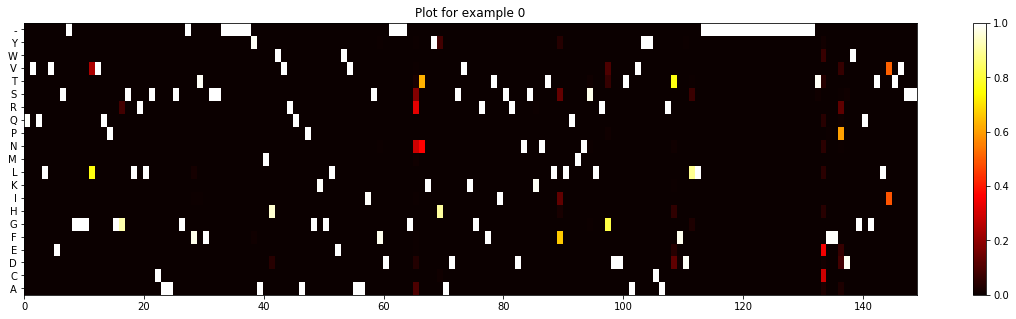

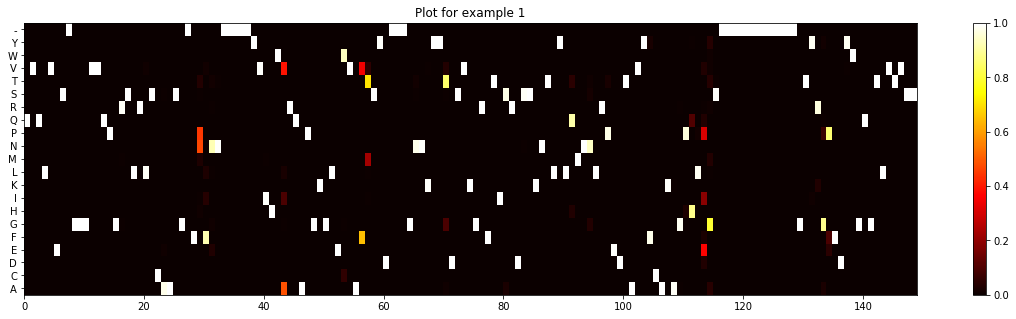

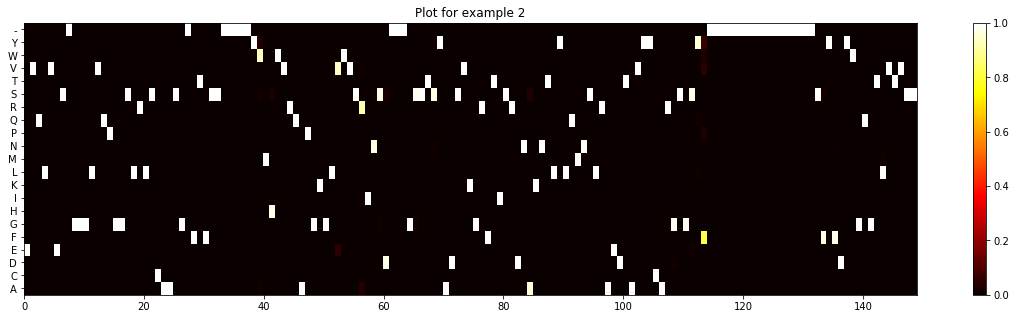

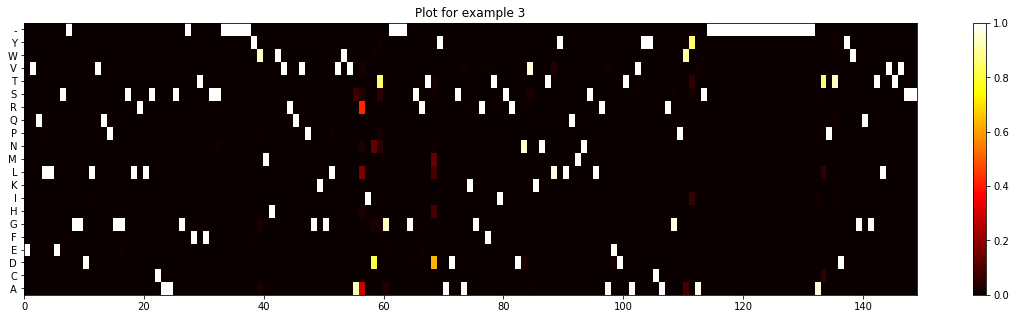

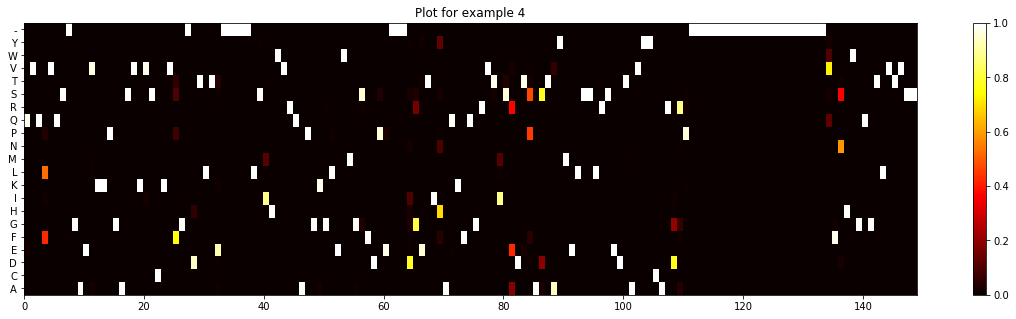

In [348]:
# For a more wholesome picture of the prediction
# we can plot the matrix of character probabilities at each position:
for i in range(0, 5):
    plt.figure(figsize=(20, 5))
    plt.title('Plot for example {}'.format(i))
    plt.pcolor(np.transpose(p_est_1000[i]), cmap="hot", vmin=0, vmax=1)
    plt.colorbar();
    plt.yticks([i+0.5 for i in range(21)], AA_ORDER);

In [349]:
# Lastly, let's sample from the latent space to generate sequences:
lsample = np.random.normal(0, 1, size=(batch_size, latent_dim))
lsample_decoded = decoder.predict(lsample)
if softmax_out is not True:
    # Normalize decoded output:
    for i in range(len(lsample_decoded)):
        lsample_decoded[i] = normalize(lsample_decoded[i], axis=1, norm='l1')
    print('This "{}" should be close to {}.'.format(sum(sum(lsample_decoded[0])), lsample_decoded.shape[1]))
lsample_sequences = onehot2seq(lsample_decoded)

In [350]:
for i, li in enumerate(lsample_sequences):
#    print(li)
    print('>', i)
    print(li.replace('-', ''))

> 0
QVELQESGGGLVKPSETLSLTCAVSGFSFSSYYWSWIRQPPGKGLEWIGYIYDSGSTNYNPSLKSRVTISVDSSKNQLSLKMNSVTAADTAVYYCAKVRGADSVDDSWGQGTLVTVSS
> 1
QVQLVQSGGEVKKPGRSVTLSCKASGYTFSSHAMHWVRQAPGQGLEWVAWTWYDNCNKYYAQSVQGRVTITRDISTSTLYMELNSLRSEDTAVYYCASGLDSSSGWVGPFDYWGQGTLVTVSS
> 2
QVQLVESGGGLVKPGGSLRLSCAASGGTISSYGWNWVRQAPGKGLEWVGYISYSGTAYYADSVKGRVTISRDNSKNTLYLQLSSLRAEDTAVYYCARVFSFFWLYYPDYWGQGTLVTVSS
> 3
EVQLVESGGGVVQPGGSLRLSCAASGFTFSSYGMSWVRQAPGKGLEWVSIIKSDGGGKYYADPVKGRFTISRDNSKNTLYFQMNSLRGEDTAVYYCATWNTYSMAAWCVDYWGQGTLVTVSS
> 4
EVQLVQSGAELKKPGDSVKVSCQVSGYPFTNSYMHWIRQAPGQGLEWIGHINPGDSETKYAESLQGRVTISRDTAKSSFYLELTSLRADDTAVYYCARGPPWGPYYDYWGQGTLVTVSS
> 5
QVQLVQSGAEVKKPEASVKVSCKTSGYTFTSYYMHWVRQAPGQGLEWMGIIFYDNGNTNYAQKFQGRVTMTRDTSTSTVYMELRSLRSDDTAVYYCARHLENGGSRSDPPFPDYWGQGTLVTVSS
> 6
QVQLQESGPGLVEPSETLSLTCAVSGDSIRRSYRWNWIRQSPGKGLEWIGEIYHSGGINYNPSLKSRVAISVDTSANYFSLKLFSVTAADTAVYYCAGVGGGSNFDLWGQGTLVTVSS
> 7
QVQLQESGPGLVKPSETLSLTCTVSGGSLSSYYWTWIRQPPGKGLEYIGSIFRSGSTNYNPSLKSRVTISVDTSKKQFSLKLSSMTAADTAVYYCARERYGGWSSLTTYGIDYWGQ

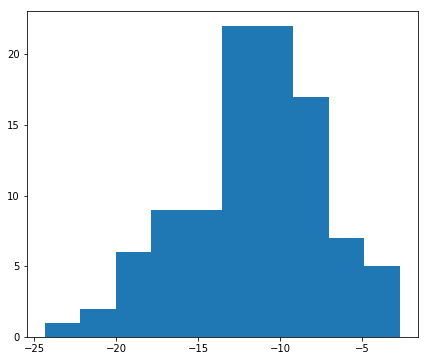

In [358]:
# What is their probabilities like:
lsample_onehot = seq2onehot(lsample_sequences)
lsample_logP = list()
for i in range(batch_size):
    lsample_logP.append(compute_log_probability(lsample_onehot[i], lsample_decoded[i]))
plt.figure(figsize=(7, 6))
plt.hist(lsample_logP);